# Concentrations and the Age of Galaxy Clusters

This notebook is an application of the xlensing code over several surveys to investigate the relationship between cluster mass concentration and observables that may relate to mass accretion age.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pyplot.style.use('ggplot')
np.set_printoptions(linewidth=400)

In [3]:


from getdist import plots, MCSamples
from astropy.table import Table

import os
import pickle

import xlensing

import emcee
import time

Lookup table loaded!


## Fetching Data

CS82: A weak-lensing survey done on stripe 82 by CFHT

In [4]:
CS82_DIR = os.path.expanduser("~/Data/CS82_REDMAPPER")
CS82_SOURCES = "sources_cleaner_final.fits"
CS82_CLUSTERS = "tcpure.fits"

DES: A multi probe modern survey on the south hemisphere

In [5]:
DES_DIR = os.path.expanduser("~/Data/DES_REDMAPPER")
DES_SOURCES = "sources_cleaner_final.fits"
DES_CLUSTERS = "tcpure.fits"

mini-J-PAS

In [6]:
JPAS_DIR = os.path.expanduser("~/Data/data_minijpas")
JPAS_PZWAV = "pzwav_SNR3.fits"

In [7]:
clusters = Table.read(os.path.join(JPAS_DIR,JPAS_PZWAV))
len(clusters)

661

In [8]:
def scatter_hist(X,Y,labels):
  figure(figsize(10,10))
  subplot(221)
  hist(X)
  subplot(223)
  scatter(X,Y)
  xlabel(labels[0])
  ylabel(labels[1])
  subplot(224)
  hist(Y,orientation='horizontal') 

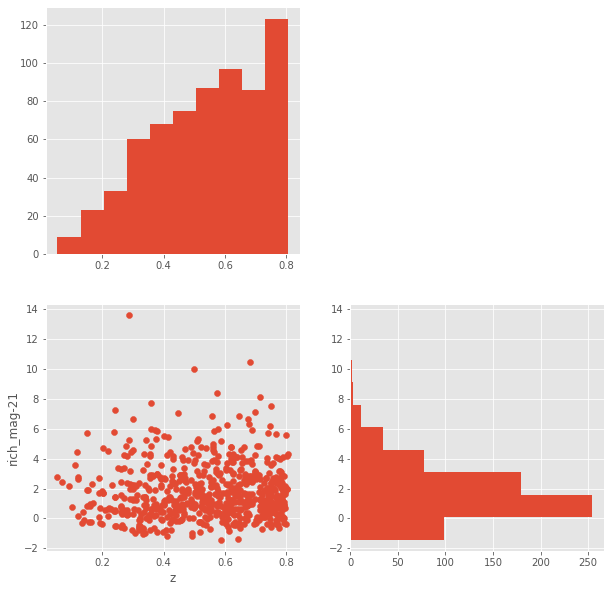

In [9]:
scatter_hist(clusters['z'],clusters['rich_mag-21'],['z','rich_mag-21'])

In [10]:
clusters.colnames

['ID',
 'RA',
 'DEC',
 'z',
 'z_err',
 'SNR',
 'richness',
 'radius',
 'rank',
 'rich_mag-21',
 'err_mag-21',
 'ra',
 'dec',
 'richness_hdbsdcan',
 'stelar_mass']

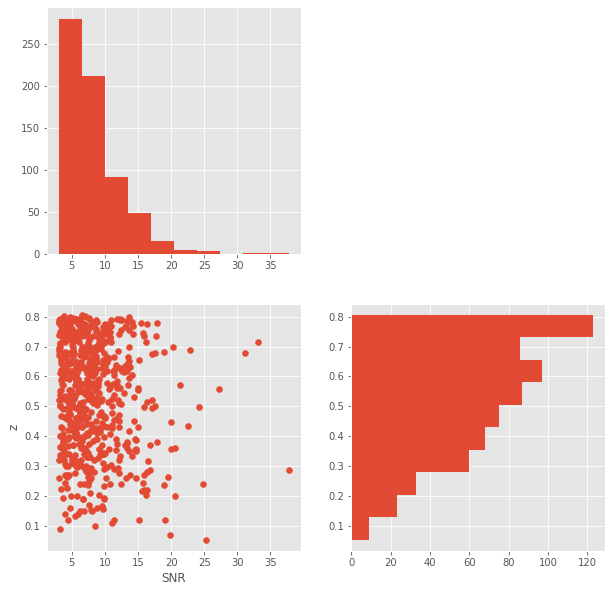

In [11]:
X, Y = "SNR", "z"
labels = [X,Y]
X = clusters[X]
Y = clusters[Y]
scatter_hist(X,Y,labels)

In [13]:
goodclusters = clusters[clusters["SNR"]>11.5]
print(len(goodclusters))

120


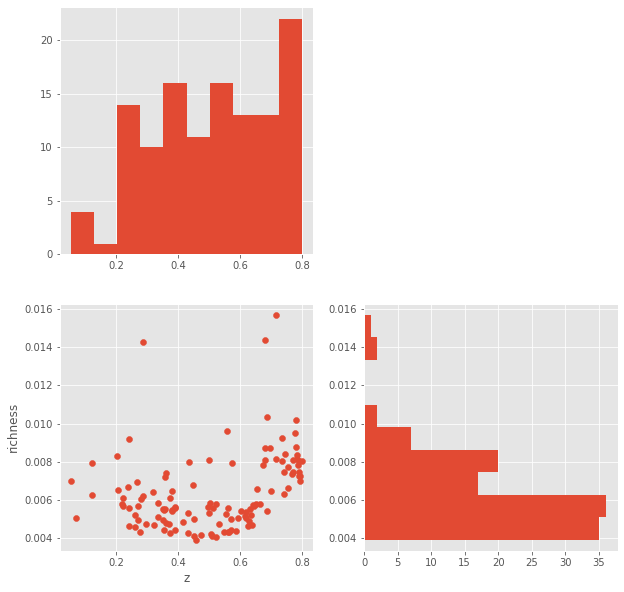

In [14]:
X, Y = "z", "richness"
labels = [X,Y]
X = goodclusters[X]
Y = goodclusters[Y]
scatter_hist(X,Y,labels)

In [4]:
sources  = Table.read(os.path.join(CS82_DIR,CS82_SOURCES))
clusters = Table.read(os.path.join(CS82_DIR,CS82_CLUSTERS))

clusters['RA_RAD'] = np.radians(clusters['RA'])
clusters['DEC_RAD']= np.radians(clusters['DEC'])
clusters['loc'] = np.array([i for i in range(len(clusters))])

sr_RA = np.radians(np.array(sources['RA']))
sr_DEC= np.radians(np.array(sources['DEC']))
sr_z  = np.array(sources['BPZ_ZPHOT'])
sr_E1 = np.array(sources['E1CORR'])
sr_E2 = np.array(sources['E2CORR'])
sr_W = np.array(sources['WEIGHT'])
sr_M = np.array(sources['M'])

clusters['INDEX'] = np.array(range(len(clusters)))

In [5]:
cl_RA=np.radians(np.array(clusters['RA']))
cl_DEC= np.radians(np.array(clusters['DEC']))
cl_z= np.array(clusters['Z'])
cl = np.array([cl_RA,cl_DEC,cl_z]).T

Getting lensing signal for all clusters:

In [6]:
#let's use multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
from functools import partial

# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(8) 


#We get a partial function with a constant galaxy catalogue to iterate with clusters.
survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, sr_DEC, sr_z, sr_E1, sr_E2, sr_W,sr_M),radius=10.)

Process ForkPoolWorker-8:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib64/python3.8/multiprocessing/process

In [7]:
#Make a list of clusters to get lensing data
clz = zip(cl_RA,cl_DEC,cl_z)
clzlist = [x for x in clz]

In [8]:
results = pool.map(survey_lensing, clzlist)

### Stacking CS82 Data

In [9]:
radii = np.logspace(-.8,.8,6)
N = len(radii)
bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                        np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])
bins_lims #in Mpc/h

array([[0.10964782, 0.22908677],
       [0.22908677, 0.47863009],
       [0.47863009, 1.        ],
       [1.        , 2.08929613],
       [2.08929613, 4.36515832],
       [4.36515832, 9.12010839]])

In [12]:
conditions =          (clusters['LAMBDA_CHISQ']<65)&\
                      (clusters['LAMBDA_CHISQ']>15)

clusters_lowz = clusters[(clusters['Z']>0.2)&
                         (clusters['Z']<0.4)&
                          conditions]

cuts = 3
clusters_lowz.sort('OFF')
partitions = [x*100/cuts for x in range(1,cuts) ]

split = list(np.percentile(np.array(range(len(clusters_lowz))),partitions).astype(int))
lowz=np.split(np.array(clusters_lowz),split)

stick = []
for stake in lowz:
    stick.append(Table(stake))

In [13]:
Nboot=500
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    for index in stake['INDEX']:
        Sigma_crit = np.array(results[index]['Critical Density'])
        e_t = np.array(results[index]['Tangential Shear'])
        e_x = np.array(results[index]['Critical Density'])
        W = np.array(results[index]['Weights'])
        M = np.array(results[index]['Mult. Bias'])
        R = np.array(results[index]['Radial Distance'])
        clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    print(len(clusterbkgs))
    sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.")






70
Total galaxies available per bin:
[803, 3496, 14827, 61587, 250219, 913140]

Stack of 70 clusters.
Done in 91.61375403404236 seconds.
71
Total galaxies available per bin:
[855, 3560, 15214, 60003, 236913, 900115]

Stack of 71 clusters.
Done in 88.88691210746765 seconds.
72
Total galaxies available per bin:
[865, 3692, 15633, 60907, 248774, 994544]

Stack of 72 clusters.
Done in 97.25718855857849 seconds.


FileNotFoundError: [Errno 2] No such file or directory: 'Results/CS82/CS82_stacking_results.pickle'

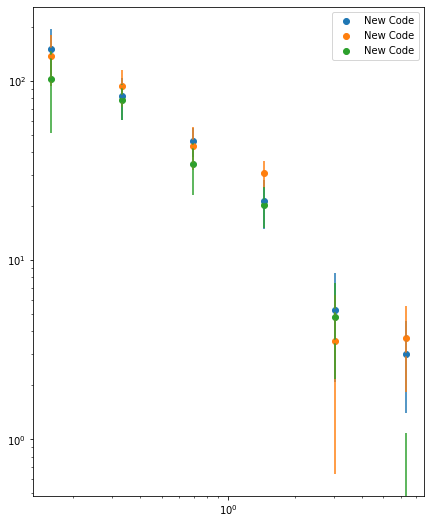

In [14]:
plt.figure(figsize=(7,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]), label = 'New Code')
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.savefig('data.pdf')

### Model

In [15]:
def NFWsimple(theta,Z,radii):
    M200, C200, PCC,  = theta
    result = xlensing.model.NFW_shear(M200, C200, Z, PCC, 0.3, 1e10,radii)['Signal']
    return result


Priors:

In [16]:
M200lo, M200hi = 1e11, 1e15
C200lo, C200hi = 0, 20
PCClo, PCChi = 0., 1
priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
prior = lambda theta : priorM200(theta) + priorC200(theta) + priorPCC(theta)

### MCMC

In [17]:
ndim, nwalkers, steps = 3, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for stickresult in stick_results:
    signal = sigmas
    covariance = sigmas_cov
    mean_z = np.average(stake['Z'])

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200,PCC]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,threads=16)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

Running MCMC...


/local/home/az264973/github/xlensing/xlensing/model.py:23: RuntimeWarning: invalid value encountered in log
  NFW_delta_c = lambda conc: (cosmo.cluster_overdensity/3.)*((conc**3)/(np.log(1.+conc)-conc/(1.+conc)))
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/xlensing/xlensing/model.py:105: RuntimeWarning: invalid value encountered in double_scalars
  radius = (3*Mvir/(12.56637*cosmo.rhoM(z)))**(1/3) #4*pi = 12.56637...
/local/home/az264973/github/xlensing/xlensing/model.py:23: RuntimeWarning: invalid value encountered in log
  NFW_delta_c = lambda conc: (cosmo.cluster_overdensity/3.)*((conc**3)/(np.log(1.+conc)-conc/(1.+conc)))
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/

Done in 199.66457223892212 seconds.
Running MCMC...


/local/home/az264973/github/xlensing/xlensing/model.py:23: RuntimeWarning: invalid value encountered in log
  NFW_delta_c = lambda conc: (cosmo.cluster_overdensity/3.)*((conc**3)/(np.log(1.+conc)-conc/(1.+conc)))
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/xlensing/xlensing/model.py:105: RuntimeWarning: invalid value encountered in double_scalars
  radius = (3*Mvir/(12.56637*cosmo.rhoM(z)))**(1/3) #4*pi = 12.56637...
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/xlensing/xlensing/model.py:105: RuntimeWarning: invalid value encountered in double_scalars
  radius = (3*Mvir/(12.56637*cosmo.rhoM(z)))**(1/3) #4*pi = 12.56637...
/local/home/az264973/github/xlensing/xlensing/mod

Done in 198.13286232948303 seconds.
Running MCMC...


/local/home/az264973/github/xlensing/xlensing/model.py:23: RuntimeWarning: invalid value encountered in log
  NFW_delta_c = lambda conc: (cosmo.cluster_overdensity/3.)*((conc**3)/(np.log(1.+conc)-conc/(1.+conc)))
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/xlensing/xlensing/model.py:105: RuntimeWarning: invalid value encountered in double_scalars
  radius = (3*Mvir/(12.56637*cosmo.rhoM(z)))**(1/3) #4*pi = 12.56637...
/local/home/az264973/github/xlensing/xlensing/model.py:27: RuntimeWarning: invalid value encountered in double_scalars
  result = ((3.*M)/(cosmo.rhocz(z)*4.*np.pi*dc))**(1./3.)
/local/home/az264973/github/xlensing/xlensing/model.py:105: RuntimeWarning: invalid value encountered in double_scalars
  radius = (3*Mvir/(12.56637*cosmo.rhoM(z)))**(1/3) #4*pi = 12.56637...
/local/home/az264973/github/xlensing/xlensing/mod

Done in 199.05113077163696 seconds.


Mvir: 3.26e+14 p 6.80e+13 m 5.86e+13
Conc: 10.90 p 4.43 m 3.51
Pcc: 0.74 p 0.07 m 0.07
Mvir: 3.51e+14 p 6.69e+13 m 6.25e+13
Conc: 9.68 p 4.05 m 2.73
Pcc: 0.74 p 0.07 m 0.07
Mvir: 2.24e+14 p 5.32e+13 m 4.87e+13
Conc: 10.16 p 5.40 m 3.72
Pcc: 0.75 p 0.07 m 0.07
Removed no burn in
Removed no burn in
Removed no burn in


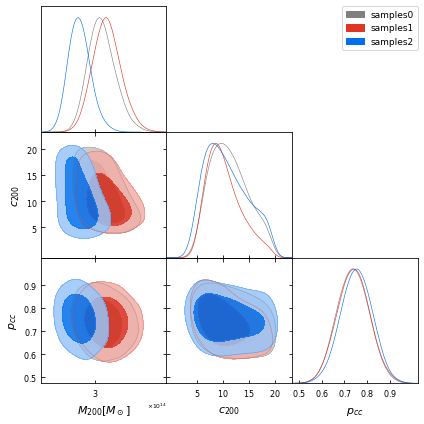

In [18]:
for samples in samplestick:
    mvir_tru,conc_tru,pcc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))

labs =  ["M_{200} [M_\\odot]", "c_{200}","p_{cc}"]

g = plots.getSubplotPlotter()
sample = [MCSamples(samples=samples, names = labs,labels=labs) for samples in samplestick]
g.triangle_plot(sample,filled=True)

## Building new likelihoods

Single cluster:

In [ ]:
stick=[cluster for cluster in clusters[clusters['Z']<0.4][0:10]]

In [ ]:
Nboot=500
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    index =stake['INDEX']
    Sigma_crit = np.array(results[index]['Critical Density'])
    e_t = np.array(results[index]['Tangential Shear'])
    e_x = np.array(results[index]['Critical Density'])
    W = np.array(results[index]['Weights'])
    M = np.array(results[index]['Mult. Bias'])
    R = np.array(results[index]['Radial Distance'])
    clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.\n")

In [ ]:
plt.figure(figsize=(7,9))

for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')

plt.xscale('log')
plt.yscale('log')
plt.savefig('data.pdf')

In [ ]:
ndim, nwalkers, steps = 3, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for j in range(len(stick_results)):
    stickresult = stick_results[j]
    signal = sigmas
    covariance = sigmas_cov
    mean_z = np.average(stick[j]['Z'])

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200,PCC]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,threads=16)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

In [ ]:
for samples in samplestick:
    mvir_tru,conc_tru,pcc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))
    print()

labs =  ["M_{200} [M_\\odot]", "c_{200}","p_{cc}"]

g = plots.getSubplotPlotter(subplot_size=6)
sample = [MCSamples(samples=samples, names = labs,labels=labs) for samples in samplestick[:-1]]

g.triangle_plot(sample,filled=True)
g.fig.savefig('single_clusters_lowz.png',bbox_inches='tight')

## mini-J-PAS Data

In [ ]:
clusters = Table.read('Data/MINI_JPAS_AMICO/AMICO_mini-JPASv3.fits')

In [ ]:
zmax=max(clusters['Z'])
print(np.degrees(10/xlensing.cosmo.DA(0,zmax)))
print(max(clusters['RA']))
print(min(clusters['RA']))
print(max(clusters['DEC']))
print(min(clusters['DEC']))

In [ ]:
sourcescfht=Table.read("Data/MINI_JPAS_AMICO/CFHTLens.tsv",format='ascii')

In [ ]:
clusters['RA','DEC']

In [ ]:
plt.figure(figsize=(2.5*10,3*10))
plt.scatter(sourcescfht['ALPHA_J2000'],sourcescfht['DELTA_J2000'],s=1,alpha=0.5)
k=0
for cluster in clusters:
    plt.scatter(cluster['RA'],cluster['DEC'],s=80,color='red')
    print(cluster['RA'],cluster['DEC'])
    
    plt.text(cluster['RA'],cluster['DEC'],"{}".format(k),fontsize=20, color='red')
    k=k+1
plt.savefig('mini_jpas_cluster_lensing.png',bbox_inches='tight')

In [ ]:
clusters

In [ ]:
sourcescfht.colnames

In [ ]:
clusters['RA_RAD'] = np.radians(clusters['RA'])
clusters['DEC_RAD']= np.radians(clusters['DEC'])
clusters['loc'] = np.array([i for i in range(len(clusters))])

sr_RA = np.radians(np.array(sourcescfht['ALPHA_J2000']))
sr_DEC= np.radians(np.array(sourcescfht['DELTA_J2000']))
sr_z  = np.array(sourcescfht['Z_B'])
sr_E1 = np.array(sourcescfht['e1'])
sr_E2 = np.array(sourcescfht['e2'])
sr_W = np.array(sourcescfht['weight'])
sr_M = np.array(sourcescfht['m'])

clusters['INDEX'] = np.array(range(len(clusters)))

In [ ]:
cl_RA=np.radians(np.array(clusters['RA']))
cl_DEC= np.radians(np.array(clusters['DEC']))
cl_z= np.array(clusters['Z'])
cl = np.array([cl_RA,cl_DEC,cl_z]).T

In [ ]:
#let's use multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
from functools import partial

# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(cpu_count()) 


#We get a partial function with a constant galaxy catalogue to iterate with clusters.
survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, sr_DEC, sr_z, sr_E1, sr_E2, sr_W,sr_M),radius=10.)

In [ ]:
#Make a list of clusters to get lensing data
clz = zip(cl_RA,cl_DEC,cl_z)
clzlist = [x for x in clz]

In [ ]:
resultsjpas = pool.map(survey_lensing, clzlist)
del pool

In [ ]:
for result in resultsjpas:
    print(result['Count'])

In [ ]:
pickle_out = open("Results/jpas_results.pickle","wb")
pickle.dump(resultsjpas, pickle_out)
pickle_out.close()

In [ ]:
stick=[cluster for cluster in clusters[0:9]]

In [ ]:
Nboot=500
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    index =stake['INDEX']
    Sigma_crit = np.array(results[index]['Critical Density'])
    e_t = np.array(results[index]['Tangential Shear'])
    e_x = np.array(results[index]['Critical Density'])
    W = np.array(results[index]['Weights'])
    M = np.array(results[index]['Mult. Bias'])
    R = np.array(results[index]['Radial Distance'])
    clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    sigmas, sigmas_cov, xigmas, xigmas_cov = xlensing.data.stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.\n")

In [ ]:
plt.figure(figsize=(7,9))
k=0
for stickresult in stick_results:
    
    plt.scatter(radii,np.array(stickresult[0]),label='{}'.format(k))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')
    k=k+1
plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.savefig('jpasdata.pdf')

In [ ]:
def NFWsimple(theta,Z,radii):
    M200, C200  = theta
    result = xlensing.model.NFW_shear(M200, C200, Z, 1.0, 0.3, 1e10,radii)['Signal']
    return result

In [ ]:
M200lo, M200hi = 1e10, 1e15
C200lo, C200hi = 0, 15
PCClo, PCChi = 0., 1
priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
#priorPCC = xlensing.fitting.ln_flat_prior_maker(PCClo, PCChi,2) ##Zhang et al. 2019
prior = lambda theta : priorM200(theta) + priorC200(theta)

In [ ]:
ndim, nwalkers, steps = 2, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for j in range(len(stick_results)):
    stickresult = stick_results[j]
    signal = sigmas
    covariance = sigmas_cov
    mean_z = np.average(stick[j]['Z'])

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        pos.append(np.array([M200,C200]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior,threads=16)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

In [ ]:
for samples in samplestick:
    mvir_tru,conc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))
    print()



In [ ]:
labs =  ["M_{200} [M_\\odot]", "c_{200}" ]

g = plots.getSubplotPlotter(subplot_size=6)
sample = [MCSamples(samples=samples, names = labs,labels=labs) for i,samples in enumerate(samplestick)]

g.triangle_plot(sample,filled=True)
g.fig.savefig('jpas_clusters_lowz.png',bbox_inches='tight')

## Multi likelihood